<a href="https://colab.research.google.com/github/ElZho/Translate-from-old-russian-language.Seq2seq-model./blob/main/Best_model_Seq2Seq_translation_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sources:**

Baseline - [Pytorch tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial)

Embeddings -https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76

https://python-school.ru/blog/word2vec-with-examples-in-gensim/

Dataloader https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

Self attention and pad_packed_sequence https://discuss.pytorch.org/t/self-attention-on-words-and-masking/5671

https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html

scheduler https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html

In this notebook I have best results with maximazing hidden size and quantity of epochs.

In [1]:
import pandas as pd
import numpy as np
#from sklearn.model_selection import train_test_split


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import tqdm
from tqdm import tqdm

In [3]:
import unicodedata
import string
import re
import random
import itertools

In [4]:
import time
import math
from collections import defaultdict

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [6]:
import os
from pathlib import Path
import sys

In [7]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r ./drive/My\ Drive/NLP_translation/* . 

Mounted at /content/drive


In [8]:
from preprocessing import prepareData, readLangs, tensorsFromPair, tensorFromSentence

Change path to dataset

In [9]:
config = {  
    'path'  :'/content/drive/MyDrive/NLP_translation/old_slav.txt', #old slavenic - rus
    #'path':'/content/rus.txt', #rus-eng
    'MAX_LENGTH':20,
    'reverse':True,
    'pad_index':[0,1],
    
    'batch_size':8, # for short datasets use batch_size - 8, for big dataset - 256

    'teacher_forcing_ratio': 0.5,
    'hidden_size':512,
    'num_epochs':100,
    
    'lr': 0.001
}

In [10]:
from model import EncoderRNN, AttnDecoderRNN, TONModel

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Load datesets and preprocess data

In [12]:
train_input_lang, train_output_lang, train_pairs, test_input_lang,\
           test_output_lang, test_pairs = prepareData('old_rus', 'new_rus', config['path'], config['MAX_LENGTH'], config['reverse'])
print(random.choice(train_pairs))

Reading lines...


100%|██████████| 229/229 [00:00<00:00, 731527.51it/s]

Read 159 sentence pairs train
Read 69 sentence pairs test
Trimmed to 150 sentence train pairs
Trimmed to 64 sentence test pairs
Counting words...
Counted words train:
old_rus 686
new_rus 642
Counted words test:
old_rus 299
new_rus 303
['иже баскаки нарицаеть тѣхъ языка рѣчь ', 'и кто называется на языке тех народов баскаками ']


Check lengths of sentences

In [ ]:
#max length of train sentence
len_train=([len(pair[0].split(' ')), len(pair[1].split(' '))] for pair in train_pairs)
max(len_train)

[24, 25]

In [ ]:
#max length of test sentence
max([len(pair[0].split(' ')), len(pair[1].split(' '))] for pair in test_pairs)

[20, 24]

In [ ]:
def len_pair(pair):
  len_0=len(pair[0].split(' '))
  len_1=len(pair[1].split(' '))
  return len_0, len_1
len_train_old=[] 
len_train_new=[] 
for pair in train_pairs:  
  old, new=len_pair(pair)
  len_train_old.append(old)
  len_train_new.append(new)

Plot histogramm for length of source sentence

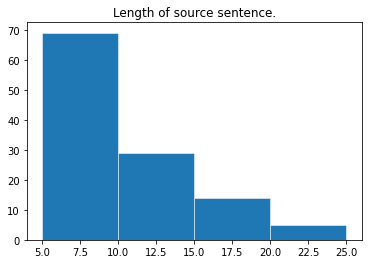

In [ ]:
fig, ax = plt.subplots()
ax.hist(len_train_old, bins=[5, 10, 15, 20, 25], linewidth=0.5, edgecolor="white")
plt.title('Length of source sentence.');



Plot histogramm for length of target sentence

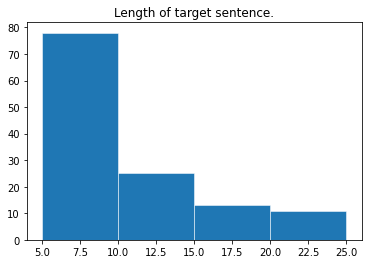

In [ ]:
fig, ax = plt.subplots()
ax.hist(len_train_new, bins=[5, 10, 15, 20, 25], linewidth=0.5, edgecolor="white")
plt.title('Length of target sentence.');

Make DataLoaders for train and test sentences.

For use dataloader I add padding sentences to max length in tensorFromSentence. 
To use pad_packed_sentence I add get_len function to get true length of sentence.

In [13]:
training_pairs = [tensorsFromPair(train_pair, train_input_lang, train_output_lang, MAX_LENGTH=config['MAX_LENGTH'])
                      for train_pair in tqdm(train_pairs)]
testing_pairs = [tensorsFromPair(test_pair, test_input_lang, test_output_lang, MAX_LENGTH=config['MAX_LENGTH'])
                      for test_pair in tqdm(test_pairs)]
train_loader = torch.utils.data.DataLoader(training_pairs, batch_size=config['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(testing_pairs, batch_size=config['batch_size'], shuffle=False)   #Test dataloader without shuffling pairs to have comparable results for validation loop                                         

100%|██████████| 64/64 [00:00<00:00, 8516.35it/s]


Make helper functions.

In [14]:
#function to check time
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [15]:
#function to plot loss curves
def plot_learning_curves(history):
    sns.set_style(style='whitegrid')
    fig = plt.figure(figsize=(10,5))

    # plt.subplot(1,3,1)
    plt.title('Loss', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.xlabel('epoch', fontsize=15)
    plt.legend()
    plt.show()

Create a traning model using dataloader.
Made changes: 
1. epoch iteration. Each epoch is train on all train dataset and validate on test dataset.
2. Encoder and decoder comunication is in model. In training model function I just pass input tensor, output tensor and input sentence length into model and get decoder output out.
3. I use batches to load data, so outputs and target have to be transformed to pass to loss function.
4. I collect train and validation loss for each epoch into defaultdict.
5. I plot train and validation loss after the training.
6. I save best model during the training.

In [17]:
#model with data loader
def train_modelIters(model, optimizer, loader, test_loader, criterion, num_epochs=6, scheduler=None):
    start = time.time() #start time
    itog_losses = []
    best_loss=np.inf #initiate best loss to check and save model with best loss.

    history = defaultdict(lambda: defaultdict(list))  #dictionry to collect losses  
      
    for epoch in tqdm(range(num_epochs), desc='epochs'):
      model.train(True)      

      plot_losses = []
      #print_loss_total = 0  
      plot_loss_total = 0

      val_losses = []
      val_loss_total = 0  
      
      #train loop
      for batch in tqdm(loader, desc='train sample batches'):
          
          input_tensor = batch[0].to(device)
          input_len=batch[1]          #true length  of sentences in batches withput padding
          target_tensor = batch[2].to(device)                           
         
          decoder_outputs, _ = model(input_tensor[:,:,0], input_len, target_tensor[:,:,0])
          
          target_tensor = target_tensor.view(-1) #change dimantion in one size
          output_dim = decoder_outputs.shape[-1]  #change dimantion in one size
          decoder_outputs=decoder_outputs.view(-1, output_dim)  #change dimantion in one size
          
          loss = criterion(decoder_outputs, target_tensor)      #calculate loss
          
          loss.backward(retain_graph=True)    
          optimizer.step()
          optimizer.zero_grad()                   
          
          plot_loss_total += loss.item() #collect losses
          
      plot_loss_avg = plot_loss_total /  len(loader)
      history['loss']['train'].append(plot_loss_avg)
      
      model.train(False)
      #validation loop
      for batch in tqdm(test_loader, desc='validation sample batches'):
        
        input_tensor = batch[0].to(device)
        input_len=batch[1]
        target_tensor = batch[2].to(device)
               
        with torch.no_grad():
          decoder_outputs, _ = model(input_tensor[:,:,0], input_len, target_tensor[:,:,0],
                                  evalute=True)
          
          target_tensor = target_tensor.view(-1)
          output_dim = decoder_outputs.shape[-1]            
          decoder_outputs=decoder_outputs.view(-1, output_dim)    
          
          val_loss = criterion(decoder_outputs, target_tensor) # calculate validation loss          
          val_loss_total+= loss.item() #collect loss item
          if scheduler!=None:
            scheduler.step(val_loss)

      val_loss_avg = val_loss_total / len(test_loader)    
      history['loss']['val'].append(val_loss_avg)
      print('Epoch train loss', plot_loss_avg, end='\n')
      print('Epoch val_loss', val_loss_avg, end='\n')

      if val_loss_avg<best_loss: #save best model
        best_loss=val_loss
        torch.save(model, '/content/drive/MyDrive/NLP_translation/best_model_rus.pt')

    plot_learning_curves(history) #plot loss curves
    return 

Train model using Adam optimizer, NLLLos and scheduler

train sample batches: 100%|██████████| 19/19 [00:01<00:00, 18.60it/s]

epochs:   1%|          | 1/100 [00:01<02:01,  1.22s/it]

Epoch train loss 5.996918402220073
Epoch val_loss 6.199577331542969



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.82it/s]

epochs:   2%|▏         | 2/100 [00:02<01:50,  1.13s/it]

Epoch train loss 5.133763790130615
Epoch val_loss 4.9073710441589355



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.36it/s]

epochs:   3%|▎         | 3/100 [00:03<01:46,  1.10s/it]

Epoch train loss 4.368383382496081
Epoch val_loss 4.341702938079834



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.80it/s]

epochs:   4%|▍         | 4/100 [00:04<01:42,  1.07s/it]

Epoch train loss 3.4209072589874268
Epoch val_loss 3.3240137100219727



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 23.15it/s]

epochs:   5%|▌         | 5/100 [00:05<01:40,  1.06s/it]

Epoch train loss 2.605388227261995
Epoch val_loss 2.5097577571868896



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.72it/s]

epochs:   6%|▌         | 6/100 [00:06<01:39,  1.06s/it]

Epoch train loss 2.134778901150352
Epoch val_loss 2.0970137119293213



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.63it/s]

epochs:   7%|▋         | 7/100 [00:07<01:38,  1.06s/it]

Epoch train loss 1.9326523040470325
Epoch val_loss 1.7337937355041504



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.84it/s]

epochs:   8%|▊         | 8/100 [00:08<01:37,  1.06s/it]

Epoch train loss 1.8210174472708451
Epoch val_loss 1.9108448028564453



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.50it/s]

epochs:   9%|▉         | 9/100 [00:09<01:37,  1.07s/it]

Epoch train loss 1.7803841892041659
Epoch val_loss 1.7461740970611572



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.56it/s]

epochs:  10%|█         | 10/100 [00:10<01:35,  1.06s/it]

Epoch train loss 1.7388966899169118
Epoch val_loss 1.3326911926269531



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.71it/s]

epochs:  11%|█         | 11/100 [00:11<01:34,  1.07s/it]

Epoch train loss 1.7838187782387984
Epoch val_loss 1.9994537830352783



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.44it/s]

epochs:  12%|█▏        | 12/100 [00:12<01:35,  1.09s/it]

Epoch train loss 1.6892788723895424
Epoch val_loss 1.478865146636963



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.99it/s]

epochs:  13%|█▎        | 13/100 [00:14<01:34,  1.09s/it]

Epoch train loss 1.6402550527923985
Epoch val_loss 1.521801471710205



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.25it/s]

epochs:  14%|█▍        | 14/100 [00:15<01:33,  1.08s/it]

Epoch train loss 1.5366081124857853
Epoch val_loss 1.0026614665985107



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 23.20it/s]

epochs:  15%|█▌        | 15/100 [00:16<01:30,  1.07s/it]

Epoch train loss 1.5447818668265092
Epoch val_loss 1.980082392692566



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.95it/s]

epochs:  16%|█▌        | 16/100 [00:17<01:28,  1.05s/it]

Epoch train loss 1.482802717309249
Epoch val_loss 1.6731168031692505



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.18it/s]

epochs:  17%|█▋        | 17/100 [00:18<01:27,  1.05s/it]

Epoch train loss 1.3749220496729802
Epoch val_loss 1.3245033025741577



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.63it/s]

epochs:  18%|█▊        | 18/100 [00:19<01:26,  1.05s/it]

Epoch train loss 1.3593333614499945
Epoch val_loss 1.129150152206421



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.71it/s]

epochs:  19%|█▉        | 19/100 [00:20<01:26,  1.07s/it]

Epoch train loss 1.2906944532143443
Epoch val_loss 1.165311336517334



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.95it/s]

epochs:  20%|██        | 20/100 [00:21<01:26,  1.08s/it]

Epoch train loss 1.2333965866189254
Epoch val_loss 1.185941457748413



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.66it/s]

epochs:  21%|██        | 21/100 [00:22<01:25,  1.08s/it]

Epoch train loss 1.1680076655588651
Epoch val_loss 0.9458308219909668



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.43it/s]

epochs:  22%|██▏       | 22/100 [00:23<01:24,  1.08s/it]

Epoch train loss 1.0583909804883755
Epoch val_loss 0.3257080018520355



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.99it/s]

epochs:  23%|██▎       | 23/100 [00:24<01:23,  1.08s/it]

Epoch train loss 1.0561060403522693
Epoch val_loss 0.8396267890930176



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.31it/s]

epochs:  24%|██▍       | 24/100 [00:25<01:22,  1.08s/it]

Epoch train loss 1.0187633963007676
Epoch val_loss 1.4144623279571533



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 23.04it/s]

epochs:  25%|██▌       | 25/100 [00:26<01:20,  1.07s/it]

Epoch train loss 0.9274817164006987
Epoch val_loss 0.6920840740203857



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.88it/s]

epochs:  26%|██▌       | 26/100 [00:27<01:18,  1.05s/it]

Epoch train loss 0.9284894811479669
Epoch val_loss 0.8197576999664307



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 23.06it/s]

epochs:  27%|██▋       | 27/100 [00:28<01:16,  1.05s/it]

Epoch train loss 0.968257254675815
Epoch val_loss 1.2886053323745728



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.46it/s]

epochs:  28%|██▊       | 28/100 [00:29<01:15,  1.05s/it]

Epoch train loss 0.8585145485244299
Epoch val_loss 0.048408620059490204



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.21it/s]

epochs:  29%|██▉       | 29/100 [00:30<01:14,  1.05s/it]

Epoch train loss 0.7954600422005904
Epoch val_loss 0.045794397592544556



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 23.18it/s]

epochs:  30%|███       | 30/100 [00:32<01:13,  1.05s/it]

Epoch train loss 0.8390855320582264
Epoch val_loss 0.8072278499603271



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.89it/s]

epochs:  31%|███       | 31/100 [00:33<01:13,  1.06s/it]

Epoch train loss 0.7676628159457132
Epoch val_loss 0.25820475816726685



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.94it/s]

epochs:  32%|███▏      | 32/100 [00:34<01:11,  1.06s/it]

Epoch train loss 0.7507434357938013
Epoch val_loss 0.7520408034324646



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.65it/s]

epochs:  33%|███▎      | 33/100 [00:35<01:11,  1.06s/it]

Epoch train loss 0.7200828963204434
Epoch val_loss 0.7402012944221497



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.78it/s]

epochs:  34%|███▍      | 34/100 [00:36<01:09,  1.06s/it]

Epoch train loss 0.6932857671850606
Epoch val_loss 0.7161521911621094



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.84it/s]

epochs:  35%|███▌      | 35/100 [00:37<01:09,  1.07s/it]

Epoch train loss 0.6705070916367205
Epoch val_loss 0.7093607187271118



train sample batches: 100%|██████████| 19/19 [00:01<00:00, 17.12it/s]

epochs:  36%|███▌      | 36/100 [00:38<01:13,  1.15s/it]

Epoch train loss 0.6311623201166329
Epoch val_loss 0.7811897993087769



train sample batches: 100%|██████████| 19/19 [00:01<00:00, 18.49it/s]

epochs:  37%|███▋      | 37/100 [00:39<01:14,  1.18s/it]

Epoch train loss 0.639108132374914
Epoch val_loss 0.16074305772781372



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.10it/s]

epochs:  38%|███▊      | 38/100 [00:41<01:11,  1.15s/it]

Epoch train loss 0.6466146944776962
Epoch val_loss 1.3629835844039917



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.82it/s]

epochs:  39%|███▉      | 39/100 [00:42<01:08,  1.12s/it]

Epoch train loss 0.6108466357384857
Epoch val_loss 0.9380943179130554



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.35it/s]

epochs:  40%|████      | 40/100 [00:43<01:05,  1.10s/it]

Epoch train loss 0.5808974705440434
Epoch val_loss 0.2513817846775055



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.09it/s]

epochs:  41%|████      | 41/100 [00:44<01:04,  1.09s/it]

Epoch train loss 0.6020725630223751
Epoch val_loss 0.4583033323287964



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.88it/s]

epochs:  42%|████▏     | 42/100 [00:45<01:03,  1.09s/it]

Epoch train loss 0.5547900426348573
Epoch val_loss 0.28828486800193787



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 23.07it/s]

epochs:  43%|████▎     | 43/100 [00:46<01:01,  1.08s/it]

Epoch train loss 0.5403754789578287
Epoch val_loss 1.1848655939102173



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 23.15it/s]

epochs:  44%|████▍     | 44/100 [00:47<00:59,  1.07s/it]

Epoch train loss 0.5195066968077108
Epoch val_loss 0.015394357033073902



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.97it/s]

epochs:  45%|████▌     | 45/100 [00:48<00:58,  1.06s/it]

Epoch train loss 0.5517315870445025
Epoch val_loss 1.527441143989563



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 23.33it/s]

epochs:  46%|████▌     | 46/100 [00:49<00:56,  1.04s/it]

Epoch train loss 0.5006653182208538
Epoch val_loss 1.5931246280670166



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 23.05it/s]

epochs:  47%|████▋     | 47/100 [00:50<00:55,  1.05s/it]

Epoch train loss 0.47952149308433656
Epoch val_loss 0.013415489345788956



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.97it/s]

epochs:  48%|████▊     | 48/100 [00:51<00:55,  1.07s/it]

Epoch train loss 0.4960312312959056
Epoch val_loss 0.17926958203315735



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.27it/s]

epochs:  49%|████▉     | 49/100 [00:52<00:55,  1.09s/it]

Epoch train loss 0.4864263414944473
Epoch val_loss 0.5172681212425232



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.15it/s]

epochs:  50%|█████     | 50/100 [00:53<00:53,  1.08s/it]

Epoch train loss 0.4211107174326715
Epoch val_loss 0.74267578125



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.48it/s]

epochs:  51%|█████     | 51/100 [00:54<00:52,  1.08s/it]

Epoch train loss 0.4071852533931011
Epoch val_loss 0.9470028281211853



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.16it/s]

epochs:  52%|█████▏    | 52/100 [00:55<00:51,  1.08s/it]

Epoch train loss 0.42042394864716026
Epoch val_loss 0.041037559509277344



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.59it/s]

epochs:  53%|█████▎    | 53/100 [00:57<00:50,  1.07s/it]

Epoch train loss 0.4262038767337799
Epoch val_loss 0.8316179513931274



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.70it/s]

epochs:  54%|█████▍    | 54/100 [00:58<00:49,  1.08s/it]

Epoch train loss 0.45932198835438803
Epoch val_loss 0.30408868193626404



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.80it/s]

epochs:  55%|█████▌    | 55/100 [00:59<00:47,  1.07s/it]

Epoch train loss 0.432159857334275
Epoch val_loss 0.6073232293128967



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.52it/s]

epochs:  56%|█████▌    | 56/100 [01:00<00:47,  1.07s/it]

Epoch train loss 0.4615816498959535
Epoch val_loss 0.013307854533195496



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.23it/s]

epochs:  57%|█████▋    | 57/100 [01:01<00:45,  1.07s/it]

Epoch train loss 0.4608412158528441
Epoch val_loss 0.022227834910154343



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.51it/s]

epochs:  58%|█████▊    | 58/100 [01:02<00:45,  1.07s/it]

Epoch train loss 0.4430804800144152
Epoch val_loss 0.49275025725364685



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.70it/s]

epochs:  59%|█████▉    | 59/100 [01:03<00:44,  1.08s/it]

Epoch train loss 0.433279446767349
Epoch val_loss 1.6199731826782227



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.52it/s]

epochs:  60%|██████    | 60/100 [01:04<00:42,  1.07s/it]

Epoch train loss 0.42636129671805784
Epoch val_loss 0.8272960782051086



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.45it/s]

epochs:  61%|██████    | 61/100 [01:05<00:41,  1.06s/it]

Epoch train loss 0.4353792100752655
Epoch val_loss 0.21766461431980133



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.32it/s]

epochs:  62%|██████▏   | 62/100 [01:06<00:40,  1.08s/it]

Epoch train loss 0.4279614926658963
Epoch val_loss 0.297380656003952



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.81it/s]

epochs:  63%|██████▎   | 63/100 [01:07<00:39,  1.07s/it]

Epoch train loss 0.4268679072051064
Epoch val_loss 1.1905484199523926



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.99it/s]

epochs:  64%|██████▍   | 64/100 [01:08<00:38,  1.07s/it]

Epoch train loss 0.43255230598151684
Epoch val_loss 0.01309165172278881



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.72it/s]

epochs:  65%|██████▌   | 65/100 [01:09<00:37,  1.08s/it]

Epoch train loss 0.42683021557566364
Epoch val_loss 0.008167058229446411



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.55it/s]

epochs:  66%|██████▌   | 66/100 [01:11<00:37,  1.09s/it]

Epoch train loss 0.3932144466395441
Epoch val_loss 0.22200368344783783



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.38it/s]

epochs:  67%|██████▋   | 67/100 [01:12<00:35,  1.09s/it]

Epoch train loss 0.38938116568973974
Epoch val_loss 0.012694035656750202



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.08it/s]

epochs:  68%|██████▊   | 68/100 [01:13<00:35,  1.10s/it]

Epoch train loss 0.38619704346025463
Epoch val_loss 0.03218282759189606



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.54it/s]

epochs:  69%|██████▉   | 69/100 [01:14<00:33,  1.09s/it]

Epoch train loss 0.43033083055266425
Epoch val_loss 0.10799319297075272



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.15it/s]

epochs:  70%|███████   | 70/100 [01:15<00:33,  1.10s/it]

Epoch train loss 0.40119721916945356
Epoch val_loss 0.008874264545738697



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.07it/s]

epochs:  71%|███████   | 71/100 [01:16<00:31,  1.10s/it]

Epoch train loss 0.38444741643769176
Epoch val_loss 1.2208119630813599



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.11it/s]

epochs:  72%|███████▏  | 72/100 [01:17<00:30,  1.09s/it]

Epoch train loss 0.3596342414078352
Epoch val_loss 0.10602449625730515



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.06it/s]

epochs:  73%|███████▎  | 73/100 [01:18<00:29,  1.09s/it]

Epoch train loss 0.3732543636211439
Epoch val_loss 1.0500715970993042



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.67it/s]

epochs:  74%|███████▍  | 74/100 [01:19<00:28,  1.09s/it]

Epoch train loss 0.3528046657723424
Epoch val_loss 0.7056578397750854



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.99it/s]

epochs:  75%|███████▌  | 75/100 [01:20<00:27,  1.09s/it]

Epoch train loss 0.39578285286399095
Epoch val_loss 0.9976240396499634



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.52it/s]

validation sample batches: 100%|██████████| 8/8 [00:00<00:00, 84.75it/s]


Epoch train loss 0.3788579967804253
Epoch val_loss 0.5854328870773315


train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.37it/s]

epochs:  77%|███████▋  | 77/100 [01:23<00:26,  1.14s/it]

Epoch train loss 0.37316185037458416
Epoch val_loss 0.007461767178028822



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.83it/s]

epochs:  78%|███████▊  | 78/100 [01:24<00:24,  1.12s/it]

Epoch train loss 0.3913240436660616
Epoch val_loss 0.37919172644615173



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.18it/s]

epochs:  79%|███████▉  | 79/100 [01:25<00:23,  1.14s/it]

Epoch train loss 0.33332181709671493
Epoch val_loss 0.6066569685935974



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.61it/s]

epochs:  80%|████████  | 80/100 [01:26<00:22,  1.13s/it]

Epoch train loss 0.3595562057422572
Epoch val_loss 0.006851211190223694



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.25it/s]

epochs:  81%|████████  | 81/100 [01:27<00:21,  1.13s/it]

Epoch train loss 0.36602006119822983
Epoch val_loss 0.7931931018829346



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.13it/s]

epochs:  82%|████████▏ | 82/100 [01:28<00:20,  1.14s/it]

Epoch train loss 0.3767652962062704
Epoch val_loss 0.27557921409606934



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.25it/s]

epochs:  83%|████████▎ | 83/100 [01:30<00:19,  1.14s/it]

Epoch train loss 0.37300337451559146
Epoch val_loss 0.008462890982627869



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.71it/s]

epochs:  84%|████████▍ | 84/100 [01:31<00:17,  1.12s/it]

Epoch train loss 0.364587383271244
Epoch val_loss 0.152323380112648



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.29it/s]

epochs:  85%|████████▌ | 85/100 [01:32<00:16,  1.12s/it]

Epoch train loss 0.34439585757392804
Epoch val_loss 0.14576545357704163



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.99it/s]

epochs:  86%|████████▌ | 86/100 [01:33<00:15,  1.11s/it]

Epoch train loss 0.34122712121001986
Epoch val_loss 0.9156821370124817



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.59it/s]

epochs:  87%|████████▋ | 87/100 [01:34<00:14,  1.12s/it]

Epoch train loss 0.38482335040737925
Epoch val_loss 0.6781064867973328



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.84it/s]

epochs:  88%|████████▊ | 88/100 [01:35<00:13,  1.10s/it]

Epoch train loss 0.38405288920100583
Epoch val_loss 0.07786624878644943



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.37it/s]

epochs:  89%|████████▉ | 89/100 [01:36<00:11,  1.09s/it]

Epoch train loss 0.38051507077915103
Epoch val_loss 0.005284096579998732



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 23.17it/s]

epochs:  90%|█████████ | 90/100 [01:37<00:10,  1.07s/it]

Epoch train loss 0.34202344127391515
Epoch val_loss 0.007631070911884308



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.90it/s]

epochs:  91%|█████████ | 91/100 [01:38<00:09,  1.06s/it]

Epoch train loss 0.3371233624455176
Epoch val_loss 0.004158732946962118



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.75it/s]

epochs:  92%|█████████▏| 92/100 [01:39<00:08,  1.07s/it]

Epoch train loss 0.39523585634551156
Epoch val_loss 0.772034227848053



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.38it/s]

epochs:  93%|█████████▎| 93/100 [01:40<00:07,  1.08s/it]

Epoch train loss 0.34856148273684084
Epoch val_loss 0.003869851352646947



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.60it/s]

epochs:  94%|█████████▍| 94/100 [01:41<00:06,  1.08s/it]

Epoch train loss 0.3413609807428561
Epoch val_loss 0.003886423073709011



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.13it/s]

epochs:  95%|█████████▌| 95/100 [01:43<00:05,  1.11s/it]

Epoch train loss 0.3760834364465585
Epoch val_loss 1.0556942224502563



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.13it/s]

epochs:  96%|█████████▌| 96/100 [01:44<00:04,  1.12s/it]

Epoch train loss 0.31633896813237744
Epoch val_loss 0.11096935719251633



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.50it/s]

epochs:  97%|█████████▋| 97/100 [01:45<00:03,  1.12s/it]

Epoch train loss 0.36935656387849075
Epoch val_loss 0.6323791742324829



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.43it/s]

epochs:  98%|█████████▊| 98/100 [01:46<00:02,  1.12s/it]

Epoch train loss 0.33786378121983845
Epoch val_loss 0.19759275019168854



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.85it/s]

epochs:  99%|█████████▉| 99/100 [01:47<00:01,  1.10s/it]

Epoch train loss 0.2876851196572381
Epoch val_loss 0.005199841223657131



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.42it/s]

epochs: 100%|██████████| 100/100 [01:48<00:00,  1.09s/it]


Epoch train loss 0.30207784410173955
Epoch val_loss 0.20092453062534332


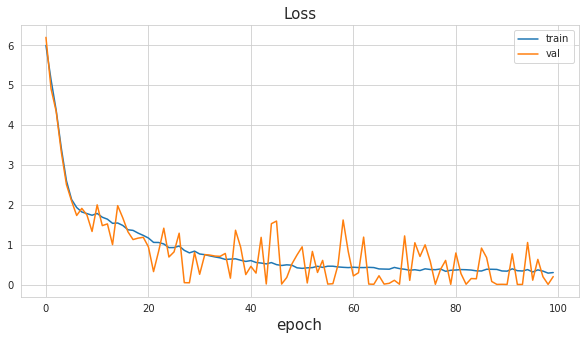

In [18]:
#model with batches rus-eng

encoder1 = EncoderRNN(train_input_lang.n_words, config['hidden_size'])
attn_decoder1 = AttnDecoderRNN(config['hidden_size'], train_output_lang.n_words, config['MAX_LENGTH'], dropout_p=0.1)
model=TONModel(encoder1, attn_decoder1, config['teacher_forcing_ratio']).to(device)

optimizer = optim.Adam(model.parameters(), lr=config['lr'])
criterion = nn.NLLLoss(ignore_index=0)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',\
#                             factor=0.95, threshold=0.1, min_lr=2e-5, verbose=True)
train_modelIters(model, optimizer, train_loader, test_loader, criterion, config['num_epochs'])

train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.20it/s]

epochs:   2%|▏         | 1/50 [00:01<00:54,  1.11s/it]

Epoch train loss 0.3031933243558007
Epoch val_loss 0.10648942738771439



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.43it/s]

epochs:   4%|▍         | 2/50 [00:02<00:52,  1.09s/it]

Epoch train loss 0.34278896275760706
Epoch val_loss 0.43471404910087585



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.81it/s]

epochs:   6%|▌         | 3/50 [00:03<00:49,  1.06s/it]

Epoch train loss 0.34742126291568737
Epoch val_loss 0.008934594690799713



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.33it/s]

epochs:   8%|▊         | 4/50 [00:04<00:48,  1.05s/it]

Epoch train loss 0.30908222606797753
Epoch val_loss 0.5499218106269836



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.13it/s]

validation sample batches: 100%|██████████| 8/8 [00:00<00:00, 71.06it/s]


Epoch train loss 0.299891371083887
Epoch val_loss 0.5383167266845703


train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.25it/s]

epochs:  12%|█▏        | 6/50 [00:06<00:49,  1.12s/it]

Epoch train loss 0.314578155300727
Epoch val_loss 0.4121476411819458



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.39it/s]

epochs:  14%|█▍        | 7/50 [00:07<00:47,  1.10s/it]

Epoch train loss 0.3233947085314675
Epoch val_loss 0.0034493543207645416



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.03it/s]

epochs:  16%|█▌        | 8/50 [00:08<00:46,  1.12s/it]

Epoch train loss 0.35070720795345933
Epoch val_loss 0.21566052734851837



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.47it/s]

epochs:  18%|█▊        | 9/50 [00:10<00:46,  1.14s/it]

Epoch train loss 0.3548127765718259
Epoch val_loss 0.0031679198145866394



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.38it/s]

epochs:  20%|██        | 10/50 [00:11<00:44,  1.12s/it]

Epoch train loss 0.2971334157658643
Epoch val_loss 0.5526575446128845



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.97it/s]

epochs:  22%|██▏       | 11/50 [00:12<00:42,  1.10s/it]

Epoch train loss 0.3345597095566949
Epoch val_loss 0.0029824301600456238



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.60it/s]

epochs:  24%|██▍       | 12/50 [00:13<00:41,  1.10s/it]

Epoch train loss 0.36092323459390746
Epoch val_loss 0.0052038137800991535



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.18it/s]

epochs:  26%|██▌       | 13/50 [00:14<00:40,  1.10s/it]

Epoch train loss 0.35060132694381635
Epoch val_loss 0.003237138967961073



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.19it/s]

epochs:  28%|██▊       | 14/50 [00:15<00:38,  1.08s/it]

Epoch train loss 0.3655948133918604
Epoch val_loss 0.46792668104171753



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.59it/s]

epochs:  30%|███       | 15/50 [00:16<00:37,  1.08s/it]

Epoch train loss 0.34151732213305014
Epoch val_loss 0.33913135528564453



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.90it/s]

epochs:  32%|███▏      | 16/50 [00:17<00:36,  1.07s/it]

Epoch train loss 0.3567775075544456
Epoch val_loss 0.0033545414917171



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 23.02it/s]

epochs:  34%|███▍      | 17/50 [00:18<00:35,  1.06s/it]

Epoch train loss 0.34194978782416957
Epoch val_loss 0.4067695438861847



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 23.24it/s]

epochs:  36%|███▌      | 18/50 [00:19<00:33,  1.05s/it]

Epoch train loss 0.32504204623891336
Epoch val_loss 0.4746257960796356



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.36it/s]

epochs:  38%|███▊      | 19/50 [00:20<00:32,  1.06s/it]

Epoch train loss 0.36717345776330484
Epoch val_loss 0.4009086489677429



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.23it/s]

epochs:  40%|████      | 20/50 [00:21<00:31,  1.06s/it]

Epoch train loss 0.3573136660270393
Epoch val_loss 0.0057826261036098



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.07it/s]

epochs:  42%|████▏     | 21/50 [00:22<00:30,  1.07s/it]

Epoch train loss 0.34765218891889643
Epoch val_loss 0.0036117308773100376



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.36it/s]

epochs:  44%|████▍     | 22/50 [00:23<00:29,  1.07s/it]

Epoch train loss 0.36785896887120445
Epoch val_loss 0.5803108215332031



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.59it/s]

epochs:  46%|████▌     | 23/50 [00:24<00:28,  1.06s/it]

Epoch train loss 0.36566008839413133
Epoch val_loss 0.14985913038253784



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.67it/s]

epochs:  48%|████▊     | 24/50 [00:26<00:27,  1.08s/it]

Epoch train loss 0.3600603941533911
Epoch val_loss 0.16461436450481415



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.98it/s]

epochs:  50%|█████     | 25/50 [00:27<00:27,  1.09s/it]

Epoch train loss 0.3491013367709361
Epoch val_loss 0.004185915924608707



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.41it/s]

epochs:  52%|█████▏    | 26/50 [00:28<00:26,  1.09s/it]

Epoch train loss 0.38422636013772143
Epoch val_loss 0.35371825098991394



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.87it/s]

epochs:  54%|█████▍    | 27/50 [00:29<00:25,  1.10s/it]

Epoch train loss 0.3626687032611747
Epoch val_loss 0.846142053604126



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.56it/s]

epochs:  56%|█████▌    | 28/50 [00:30<00:24,  1.12s/it]

Epoch train loss 0.3878702295110806
Epoch val_loss 0.006477804388850927



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.40it/s]

epochs:  58%|█████▊    | 29/50 [00:31<00:23,  1.11s/it]

Epoch train loss 0.40537409893678206
Epoch val_loss 1.321531057357788



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.50it/s]

epochs:  60%|██████    | 30/50 [00:32<00:21,  1.10s/it]

Epoch train loss 0.41169192922595693
Epoch val_loss 0.003289218293502927



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.92it/s]

epochs:  62%|██████▏   | 31/50 [00:33<00:20,  1.09s/it]

Epoch train loss 0.398368157176791
Epoch val_loss 0.7046594023704529



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.35it/s]

epochs:  64%|██████▍   | 32/50 [00:34<00:19,  1.10s/it]

Epoch train loss 0.3740075276429324
Epoch val_loss 0.7358352541923523



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.67it/s]

epochs:  66%|██████▌   | 33/50 [00:36<00:18,  1.12s/it]

Epoch train loss 0.3324697742875862
Epoch val_loss 0.009959505870938301



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.41it/s]

epochs:  68%|██████▊   | 34/50 [00:37<00:17,  1.10s/it]

Epoch train loss 0.32050155376476286
Epoch val_loss 0.4670780301094055



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.27it/s]

epochs:  70%|███████   | 35/50 [00:38<00:16,  1.10s/it]

Epoch train loss 0.3177875162739503
Epoch val_loss 0.19097724556922913



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.63it/s]

epochs:  72%|███████▏  | 36/50 [00:39<00:15,  1.12s/it]

Epoch train loss 0.3442410101599403
Epoch val_loss 0.41525086760520935



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.35it/s]

epochs:  74%|███████▍  | 37/50 [00:40<00:14,  1.12s/it]

Epoch train loss 0.321148040496107
Epoch val_loss 0.004851074423640966



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.78it/s]

epochs:  76%|███████▌  | 38/50 [00:41<00:13,  1.12s/it]

Epoch train loss 0.3389560154663693
Epoch val_loss 0.21787667274475098



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.97it/s]

epochs:  78%|███████▊  | 39/50 [00:42<00:12,  1.11s/it]

Epoch train loss 0.3604840315437238
Epoch val_loss 0.5442072749137878



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.25it/s]

epochs:  80%|████████  | 40/50 [00:43<00:11,  1.12s/it]

Epoch train loss 0.3603597084844583
Epoch val_loss 0.625543475151062



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.39it/s]

epochs:  82%|████████▏ | 41/50 [00:44<00:09,  1.11s/it]

Epoch train loss 0.36119505846382755
Epoch val_loss 0.00149623304605484



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.19it/s]

epochs:  84%|████████▍ | 42/50 [00:46<00:09,  1.13s/it]

Epoch train loss 0.3331717192501712
Epoch val_loss 0.12897531688213348



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.45it/s]

epochs:  86%|████████▌ | 43/50 [00:47<00:07,  1.13s/it]

Epoch train loss 0.38519531668555973
Epoch val_loss 0.15603062510490417



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.54it/s]

epochs:  88%|████████▊ | 44/50 [00:48<00:06,  1.12s/it]

Epoch train loss 0.3318501284444018
Epoch val_loss 0.0032649643253535032



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.53it/s]

epochs:  90%|█████████ | 45/50 [00:49<00:05,  1.11s/it]

Epoch train loss 0.37745438780831664
Epoch val_loss 0.932532787322998



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.50it/s]

epochs:  92%|█████████▏| 46/50 [00:50<00:04,  1.10s/it]

Epoch train loss 0.37998363217584
Epoch val_loss 0.614514946937561



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.65it/s]

epochs:  94%|█████████▍| 47/50 [00:51<00:03,  1.12s/it]

Epoch train loss 0.32032436718183915
Epoch val_loss 0.002220634836703539



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.96it/s]

epochs:  96%|█████████▌| 48/50 [00:52<00:02,  1.11s/it]

Epoch train loss 0.37336573623561936
Epoch val_loss 0.553467869758606



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.07it/s]

epochs:  98%|█████████▊| 49/50 [00:53<00:01,  1.12s/it]

Epoch train loss 0.33521619489367466
Epoch val_loss 0.6255819201469421



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.96it/s]

epochs: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]


Epoch train loss 0.34669834885158035
Epoch val_loss 0.005226270295679569


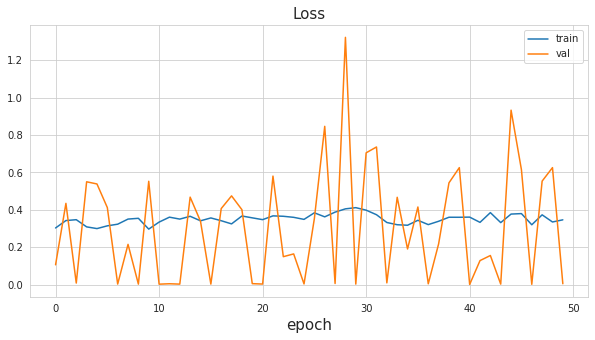

In [53]:
train_modelIters(model, optimizer, train_loader, test_loader, criterion, 50)

Result is worse then I expected. Final learning rate is bigger then without scheduler and model stoped to improving.

Let's look at the translation result and calculate metric. 

In [ ]:
#from torchtext.data.metrics import bleu_score 

In [40]:
from sklearn.metrics import precision_score

In [23]:
from nltk.translate.bleu_score import sentence_bleu

In [24]:
from nltk.translate.bleu_score import SmoothingFunction

In [43]:
def bleu_score(predict, target):
  
  p=len(predict)
  t=len(target)
  k=t-p  
  if k>0:
    predict.extend(itertools.repeat(0, abs(k)))
  elif k<0 : 
    target.extend(itertools.repeat(0, abs(k)))
  if min(p, t)<2:    
    bleu_itog=precision_score(target, predict, average='micro',zero_division=0)
  else:
    n=min(p, t, 4)  
  bleu=np.zeros(n)
  bleu[0]=precision_score(target, predict, average='micro', zero_division=0)
  for i in range(2, n+1):
    y_pred=[predict[idx:idx+i] for idx in range(n-i+1)]
    y_true=[target[idx:idx+i] for idx in range(n-i+1)]
    bleu[i-1]=np.mean([precision_score(y_true[idx], y_pred[idx], average='micro', zero_division=0) for idx in range(n-i+1)])
    
  bleu_itog= bleu.mean() 
  return  bleu_itog 

In [41]:
def evaluateRandomly(model, pairs, input_lang, output_lang, n=10):
    for i in range(n):
        outputs=[]
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        
        input_tensor = tensorFromSentence(input_lang, pair[0], config['MAX_LENGTH'])
        input_len=torch.tensor([len(pair[0].split(' '))], dtype=torch.int64)
        target_tensor=tensorFromSentence(output_lang, pair[1], config['MAX_LENGTH'])
                
        output_words, _ = model(input_tensor.reshape(1,config['MAX_LENGTH']), input_len, target_tensor.reshape(1,config['MAX_LENGTH']), evalute=True)    
        
        result=output_words.argmax(2).detach()
        result=result.squeeze(0)
        
        for idx in range(result.shape[0]):
            tok=train_output_lang.index2word[result[idx].item()]
            if tok=='EOS':
              break
            outputs.append(tok) 
        #print(bleu_score(result.tolist(), target_tensor.tolist()))      
        output_sentence = ' '.join(outputs)
        print('<', output_sentence)
        print('')
        
        print('Blue score of this sentence  - ', sentence_bleu(outputs, pair[1].split(' '), smoothing_function=SmoothingFunction().method1))
        print('')
        print('Blue score of this sentence my function - ', bleu_score(result.tolist(), target_tensor.tolist()))
        print('======================================')

In [47]:
len(train_pairs)

150

In [50]:
def count_bleu(model, pairs, input_lang, output_lang):
  bleu=[]
  for pair in pairs:
      with torch.no_grad():  
        input_tensor = tensorFromSentence(input_lang, pair[0], config['MAX_LENGTH'])
        input_len=torch.tensor([len(pair[0].split(' '))], dtype=torch.int64)
        target_tensor=tensorFromSentence(output_lang, pair[1], config['MAX_LENGTH'])
                
        output_words, _ = model(input_tensor.reshape(1,config['MAX_LENGTH']), input_len, target_tensor.reshape(1,config['MAX_LENGTH']), evalute=True)    
        
        result=output_words.argmax(2).detach()
        result=result.squeeze(0)
        result=result.tolist()
        targ=  target_tensor.tolist()
        bleu.append(bleu_score(result, target_tensor.tolist()))
  return  np.mean(bleu)   


In [51]:
#train old slav - rus
count_bleu(model, train_pairs, train_input_lang, train_output_lang)

0.8643055555555554

In [52]:
#test old slav - rus
count_bleu(model, test_pairs, test_input_lang, test_output_lang)

0.109375

In [54]:
#test old slav - rus after 150 epochs
count_bleu(model, test_pairs, test_input_lang, test_output_lang)

0.11067708333333333

In [44]:
evaluateRandomly(model, train_pairs, train_input_lang, train_output_lang, n=1)

> горлица моужелюбица пътахъ есть 
= горлица – птица  любящая своего супруга 
< горлица – птица  любящая своего супруга  любящая

Blue score of this sentence  -  0.02777619034011792

Blue score of this sentence my function -  0.9875


In [45]:
evaluateRandomly(model, train_pairs, train_input_lang, train_output_lang)

> и приведоша ѥго ко кнѧзю
= и привели его ко князю 
< и привели его ко князю               

Blue score of this sentence  -  0.040824829046386304

Blue score of this sentence my function -  0.825
> то привести ему послухъ слово противъ слова 
= то ему следует привести свидетеля для показании 
< то ему следует привести свидетеля для показании  для

Blue score of this sentence  -  0

Blue score of this sentence my function -  0.9875
> и приведоша ѥго ко кнѧзю
= и привели его ко князю 
< и привели его ко князю               

Blue score of this sentence  -  0.040824829046386304

Blue score of this sentence my function -  0.825
> поступаи княже 
= иди вперед  князь
< иди вперед  князь  князь  князь  князь  князь  князь  князь  князь  князь

Blue score of this sentence  -  0

Blue score of this sentence my function -  0.8
> спасти же прочаа 
= спасти оставшихся 
< спасти оставшихся  

Blue score of this sentence  -  0

Blue score of this sentence my function -  0.8416666666666666
> и приве

In [26]:
evaluateRandomly(model, train_pairs, train_input_lang, train_output_lang)

> а вьсемъ людемъ пророкъ показасѧ 
= а всем людям явился пророком 
< а всем людям явился пророком  явился

Blue score of this sentence  -  0.040824829046386304

> прииде же и богатьства иӡъобилование въ съкровища ихъ 
= пришло изобилие богатств в их сокровищницах 
< пришло изобилие богатств в их сокровищницах  их сокровищницах  их сокровищницах  их сокровищницах  их сокровищницах  их

Blue score of this sentence  -  0.033031643180138064

> со всею князьею  но сами поидоша ѡ собѣ 
= со всеми князьями  но пошли сами по себе 
< со всеми князьями  но пошли сами по себе  но пошли сами по себе  но пошли сами по

Blue score of this sentence  -  0

> оправдивъ животъ
= я исправил жизнь свою
< я исправил жизнь свою свою

Blue score of this sentence  -  0.08034284189446518

> и се приидоша страньници в градъ тъ 
= и вот в тот город пришли странники 
< и вот в тот город пришли странники  пришли странники  пришли странники  пришли странники  пришли странники 

Blue score of this sentence  -  0.02

In [46]:
evaluateRandomly(model, test_pairs, test_input_lang, test_output_lang)

> да аще бо погибнеть единъ ею 
= и если погибнет один из них 
< а всем людям явился пророком               

Blue score of this sentence  -  0.033031643180138064

Blue score of this sentence my function -  0.0
> а отъ бога грѣхъ 
= и от бога грех 
< а вышел не еще и свою

Blue score of this sentence  -  0.05372849659117709

Blue score of this sentence my function -  0.175
> таче пришедъши мати ѥго по двою дьнию отрѣши и от столпа и подасть ѥмоу ясти 
= придя через два дня  его мать отвязала его и дала ему есть 
< и посадили его ко князю  и посадили его ко князю  и посадили его ко князю  и посадили

Blue score of this sentence  -  0.01428363257865929

Blue score of this sentence my function -  0.0
> молѧщасѧ прилѣжно великомy мyченикy никитѣ и пытающy  гдѣ ѥсть образъ ѥго 
= которыи усердно молился великомученику никите и пытался узнать  где находится его икона 
< а  всем   к вышел  явился   всем  пророком 

Blue score of this sentence  -  0.01428363257865929

Blue score of this senten

In [27]:
evaluateRandomly(model, test_pairs, test_input_lang, test_output_lang)

> и неправеднаго собрания
= и неправедного общества 
< уродливыи                   

Blue score of this sentence  -  0.08034284189446518

> мнитъ сѧ не согрѣшаѧ къ богy  и есть поганого горѣе  и обѣщникъ есть нечестивымъ
= считающии себя праведным перед богом  но он хуже язычника  сообщник нечестивых 
< то такои подобен стене                

Blue score of this sentence  -  0

> блюдоущи да не пакы отъбѣжить отъ нея 
= опасаясь  что он снова убежит от нее 
< особенно же почитаите гостя                

Blue score of this sentence  -  0

> а ѿ людеи посмѣхъ 
= и от людеи насмешка 
< то вышел не  привести 

Blue score of this sentence  -  0.05372849659117709

> то начьняше мьнѣти моужа ю соуща 
= то думал  что это мужчина 
< то рухнет                  

Blue score of this sentence  -  0

> блажьнныи же александръ слезами ѡбливаясѧ глаголѧ кто есмь азъ грѣшникъ
= блаженныи же александр со слезами говорил: «кто я такои  грешник 
< пелеи же  колкос обошел обошел обошел обошел обошел обошел 

In [31]:
import matplotlib as mpl

In [28]:
def evaluate(model, pairs, input_lang=train_input_lang, output_lang=train_output_lang):
    outputs=[]        
    input_tensor = tensorFromSentence(input_lang, pairs[0], config['MAX_LENGTH'])
    input_len=torch.tensor([len(pairs[0].split(' '))], dtype=torch.int64)
    target_tensor=tensorFromSentence(output_lang, pairs[1], config['MAX_LENGTH'])
                
    output_words, attention = model(input_tensor.reshape(1,config['MAX_LENGTH']), input_len, target_tensor.reshape(1,config['MAX_LENGTH']), evalute=True)    
        
    result=output_words.argmax(2).detach()
    result=result.squeeze(0)
        
    for idx in range(result.shape[0]):
        tok=train_output_lang.index2word[result[idx].item()]
        if tok=='EOS':
          break
        outputs.append(tok) 
             
        output_sentence = ' '.join(outputs)
    return    outputs,  attention

In [34]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze().cpu().detach()
    a=torch.zeros(len(attention), len(attention))
    for idx in range(len(attention)):
      a[idx,idx]=attention[idx]
    cax = ax.matshow(a.numpy(), cmap=mpl.cm.cool)
   
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + [t.lower() for t in sentence]
    y_ticks = [''] + translation
    
    ax.set_xticklabels(x_ticks, rotation=90)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

def evaluateAndShowAttention(input_sentence, model=model):
    output_words, attentions = evaluate(model, input_sentence)
    print('input =', input_sentence[0])
    print('output =', ' '.join(output_words))
    attentions=attentions.detach()
    
    display_attention(input_sentence[0].split(' '), output_words, attentions)



input = разумѣя убо пелеи  яже колкосъ осътровъ моремъ обшелъ 
output = пелеи же  по обошел обошел обошел обошел обошел обошел обошел обошел обошел обошел обошел обошел обошел обошел обошел обошел


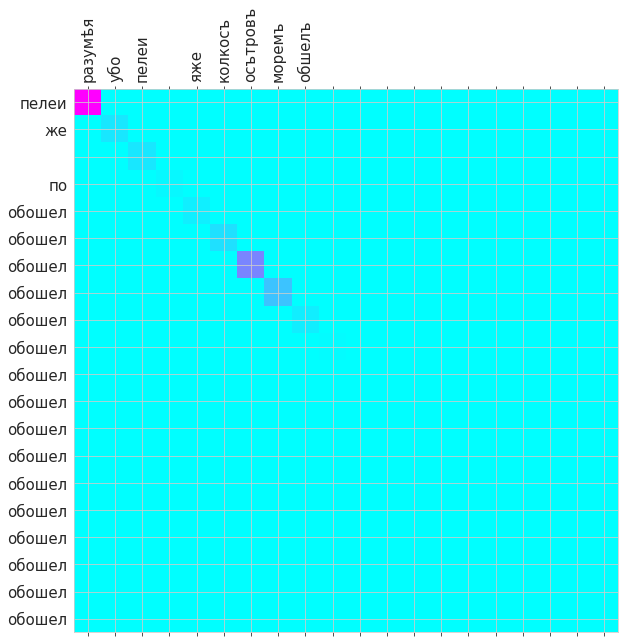

In [39]:
evaluateAndShowAttention(random.choice(train_pairs))

input = и что языкъ ихъ  и котораго племене суть 
output = и что у них за язык  язык  язык  язык  язык  язык  язык  язык


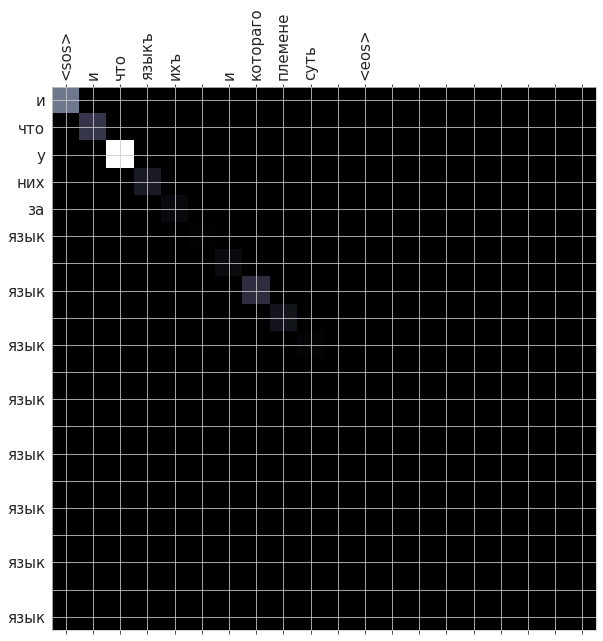

In [30]:
evaluateAndShowAttention(random.choice(train_pairs))



In [55]:
config = {  
    'path'  :'/content/drive/MyDrive/NLP_translation/old_slav.txt', #old slavenic - rus
    #'path':'/content/rus.txt', #rus-eng
    'MAX_LENGTH':20,
    'reverse':True,
    'pad_index':[0,1],
    
    'batch_size':8, # for short datasets use batch_size - 8, for big dataset - 256

    'teacher_forcing_ratio': 0.5,
    'hidden_size':768,
    'num_epochs':100,
    
    'lr': 0.001
}

train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.44it/s]

epochs:   1%|          | 1/100 [00:01<01:57,  1.18s/it]

Epoch train loss 5.987539567445454
Epoch val_loss 6.269880294799805



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.70it/s]

epochs:   2%|▏         | 2/100 [00:02<01:55,  1.17s/it]

Epoch train loss 4.86858962711535
Epoch val_loss 4.551412105560303



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.47it/s]

epochs:   3%|▎         | 3/100 [00:03<01:54,  1.19s/it]

Epoch train loss 3.5969649867007605
Epoch val_loss 3.739408016204834



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.42it/s]

epochs:   4%|▍         | 4/100 [00:04<01:54,  1.19s/it]

Epoch train loss 2.439113127557855
Epoch val_loss 2.252960443496704



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.81it/s]

epochs:   5%|▌         | 5/100 [00:05<01:53,  1.20s/it]

Epoch train loss 2.0134967251827844
Epoch val_loss 1.8609625101089478



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.61it/s]

epochs:   6%|▌         | 6/100 [00:07<01:52,  1.20s/it]

Epoch train loss 2.0475448746430245
Epoch val_loss 2.60878849029541



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.83it/s]

epochs:   7%|▋         | 7/100 [00:08<01:51,  1.20s/it]

Epoch train loss 2.0986003938474154
Epoch val_loss 2.3421006202697754



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.26it/s]

epochs:   8%|▊         | 8/100 [00:09<01:50,  1.20s/it]

Epoch train loss 2.124300103438528
Epoch val_loss 2.0153615474700928



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.62it/s]

epochs:   9%|▉         | 9/100 [00:10<01:49,  1.20s/it]

Epoch train loss 1.9696839483160722
Epoch val_loss 2.5085055828094482



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.31it/s]

epochs:  10%|█         | 10/100 [00:11<01:47,  1.20s/it]

Epoch train loss 1.9773270205447548
Epoch val_loss 2.1090281009674072



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.98it/s]

epochs:  11%|█         | 11/100 [00:13<01:47,  1.21s/it]

Epoch train loss 1.8780895283347683
Epoch val_loss 2.3442130088806152



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.77it/s]

epochs:  12%|█▏        | 12/100 [00:14<01:45,  1.20s/it]

Epoch train loss 1.7499376629528247
Epoch val_loss 1.9020869731903076



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.95it/s]

epochs:  13%|█▎        | 13/100 [00:15<01:44,  1.20s/it]

Epoch train loss 1.6515050812771446
Epoch val_loss 1.0091139078140259



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.68it/s]

epochs:  14%|█▍        | 14/100 [00:16<01:42,  1.19s/it]

Epoch train loss 1.6318559081930863
Epoch val_loss 0.7883992195129395



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.53it/s]

epochs:  15%|█▌        | 15/100 [00:17<01:42,  1.21s/it]

Epoch train loss 1.4704880055628324
Epoch val_loss 0.6433376669883728



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.06it/s]

epochs:  16%|█▌        | 16/100 [00:19<01:40,  1.20s/it]

Epoch train loss 1.4491316142835116
Epoch val_loss 1.4415507316589355



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.34it/s]

epochs:  17%|█▋        | 17/100 [00:20<01:39,  1.20s/it]

Epoch train loss 1.3314018045601093
Epoch val_loss 1.265971302986145



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.25it/s]

epochs:  18%|█▊        | 18/100 [00:21<01:38,  1.21s/it]

Epoch train loss 1.273388192841881
Epoch val_loss 1.4862138032913208



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.62it/s]

epochs:  19%|█▉        | 19/100 [00:22<01:36,  1.19s/it]

Epoch train loss 1.1530449751176333
Epoch val_loss 0.9535357356071472



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.25it/s]

epochs:  20%|██        | 20/100 [00:23<01:36,  1.20s/it]

Epoch train loss 1.1255813711567928
Epoch val_loss 1.405139684677124



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.72it/s]

epochs:  21%|██        | 21/100 [00:25<01:35,  1.20s/it]

Epoch train loss 1.049612056267889
Epoch val_loss 1.6647926568984985



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.01it/s]

epochs:  22%|██▏       | 22/100 [00:26<01:34,  1.21s/it]

Epoch train loss 1.0395224470841258
Epoch val_loss 1.8096212148666382



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.58it/s]

epochs:  23%|██▎       | 23/100 [00:27<01:32,  1.20s/it]

Epoch train loss 1.0014795143353312
Epoch val_loss 0.8168445825576782



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.31it/s]

epochs:  24%|██▍       | 24/100 [00:28<01:31,  1.20s/it]

Epoch train loss 0.9544765259090223
Epoch val_loss 1.2716479301452637



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.58it/s]

epochs:  25%|██▌       | 25/100 [00:30<01:30,  1.21s/it]

Epoch train loss 0.8893596953467319
Epoch val_loss 0.8668235540390015



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.33it/s]

epochs:  26%|██▌       | 26/100 [00:31<01:28,  1.19s/it]

Epoch train loss 0.8940577083512357
Epoch val_loss 0.8696094751358032



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.14it/s]

validation sample batches: 100%|██████████| 8/8 [00:00<00:00, 63.33it/s]


Epoch train loss 0.8373884069488237
Epoch val_loss 1.4054393768310547


train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.06it/s]

epochs:  28%|██▊       | 28/100 [00:33<01:27,  1.21s/it]

Epoch train loss 0.8067358496942019
Epoch val_loss 0.43409842252731323



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.05it/s]

epochs:  29%|██▉       | 29/100 [00:34<01:26,  1.21s/it]

Epoch train loss 0.7915156328756559
Epoch val_loss 1.0671614408493042



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.36it/s]

epochs:  30%|███       | 30/100 [00:36<01:24,  1.21s/it]

Epoch train loss 0.7726050474141773
Epoch val_loss 1.271415114402771



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 19.26it/s]

epochs:  31%|███       | 31/100 [00:37<01:24,  1.23s/it]

Epoch train loss 0.7644766827947215
Epoch val_loss 1.7233153581619263



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.86it/s]

epochs:  32%|███▏      | 32/100 [00:38<01:23,  1.23s/it]

Epoch train loss 0.7158038976945376
Epoch val_loss 0.48217999935150146



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.46it/s]

validation sample batches: 100%|██████████| 8/8 [00:00<00:00, 44.29it/s]


Epoch train loss 0.733682245016098
Epoch val_loss 0.6977319121360779


train sample batches: 100%|██████████| 19/19 [00:01<00:00, 18.40it/s]

epochs:  34%|███▍      | 34/100 [00:41<01:26,  1.31s/it]

Epoch train loss 0.7060218171069497
Epoch val_loss 0.20728394389152527



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.02it/s]

epochs:  35%|███▌      | 35/100 [00:42<01:23,  1.29s/it]

Epoch train loss 0.6935597801286923
Epoch val_loss 0.055150534957647324



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.48it/s]

epochs:  36%|███▌      | 36/100 [00:43<01:20,  1.26s/it]

Epoch train loss 0.7037780865242607
Epoch val_loss 1.7715333700180054



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.06it/s]

epochs:  37%|███▋      | 37/100 [00:44<01:18,  1.25s/it]

Epoch train loss 0.6913016046348371
Epoch val_loss 1.342776894569397



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.95it/s]

epochs:  38%|███▊      | 38/100 [00:46<01:16,  1.24s/it]

Epoch train loss 0.6513897950613969
Epoch val_loss 0.02393866702914238



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 19.86it/s]

epochs:  39%|███▉      | 39/100 [00:47<01:15,  1.24s/it]

Epoch train loss 0.669974010241659
Epoch val_loss 0.6911173462867737



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.80it/s]

epochs:  40%|████      | 40/100 [00:48<01:13,  1.23s/it]

Epoch train loss 0.6459387623655953
Epoch val_loss 0.38667675852775574



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.50it/s]

epochs:  41%|████      | 41/100 [00:49<01:12,  1.22s/it]

Epoch train loss 0.5868434757974587
Epoch val_loss 0.01268375851213932



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.59it/s]

epochs:  42%|████▏     | 42/100 [00:51<01:10,  1.21s/it]

Epoch train loss 0.6077417865591613
Epoch val_loss 0.5051423907279968



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.71it/s]

epochs:  43%|████▎     | 43/100 [00:52<01:08,  1.21s/it]

Epoch train loss 0.6124428173429087
Epoch val_loss 1.2014365196228027



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.32it/s]

epochs:  44%|████▍     | 44/100 [00:53<01:07,  1.20s/it]

Epoch train loss 0.5995027697890213
Epoch val_loss 0.7451921701431274



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.19it/s]

validation sample batches: 100%|██████████| 8/8 [00:00<00:00, 85.63it/s]


Epoch train loss 0.5822756103190937
Epoch val_loss 1.4156694412231445


train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.48it/s]

epochs:  46%|████▌     | 46/100 [00:56<01:06,  1.24s/it]

Epoch train loss 0.5321969238207921
Epoch val_loss 0.007652981672435999



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 19.73it/s]

epochs:  47%|████▋     | 47/100 [00:57<01:12,  1.36s/it]

Epoch train loss 0.5316829817173513
Epoch val_loss 0.16708806157112122



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 19.97it/s]

epochs:  48%|████▊     | 48/100 [00:58<01:08,  1.32s/it]

Epoch train loss 0.5198690073662683
Epoch val_loss 1.2013314962387085



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.95it/s]

epochs:  49%|████▉     | 49/100 [01:00<01:06,  1.30s/it]

Epoch train loss 0.5108336802375945
Epoch val_loss 0.014136427082121372



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.52it/s]

epochs:  50%|█████     | 50/100 [01:01<01:03,  1.26s/it]

Epoch train loss 0.47453838846597235
Epoch val_loss 0.23390153050422668



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.56it/s]

epochs:  51%|█████     | 51/100 [01:02<01:01,  1.25s/it]

Epoch train loss 0.49394585692176696
Epoch val_loss 0.24720801413059235



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.92it/s]

epochs:  52%|█████▏    | 52/100 [01:03<00:59,  1.23s/it]

Epoch train loss 0.5111016919346232
Epoch val_loss 0.35688188672065735



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.20it/s]

epochs:  53%|█████▎    | 53/100 [01:04<00:57,  1.23s/it]

Epoch train loss 0.4702637396066597
Epoch val_loss 0.005908532068133354



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 22.11it/s]

epochs:  54%|█████▍    | 54/100 [01:06<00:56,  1.22s/it]

Epoch train loss 0.48405589249083086
Epoch val_loss 0.8714146018028259



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 19.97it/s]

epochs:  55%|█████▌    | 55/100 [01:07<00:55,  1.23s/it]

Epoch train loss 0.46558530403203086
Epoch val_loss 0.44799140095710754



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 19.70it/s]

epochs:  56%|█████▌    | 56/100 [01:08<00:54,  1.24s/it]

Epoch train loss 0.46835031411855627
Epoch val_loss 0.31328117847442627



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.61it/s]

epochs:  57%|█████▋    | 57/100 [01:09<00:53,  1.23s/it]

Epoch train loss 0.47067940347876985
Epoch val_loss 0.25007012486457825



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.97it/s]

epochs:  58%|█████▊    | 58/100 [01:11<00:51,  1.23s/it]

Epoch train loss 0.4348830487334022
Epoch val_loss 0.12966293096542358



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 19.78it/s]

epochs:  59%|█████▉    | 59/100 [01:12<00:50,  1.23s/it]

Epoch train loss 0.4637783977791275
Epoch val_loss 0.4716501832008362



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.11it/s]

epochs:  60%|██████    | 60/100 [01:13<00:48,  1.22s/it]

Epoch train loss 0.4241914094278687
Epoch val_loss 0.5698348879814148



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.84it/s]

epochs:  61%|██████    | 61/100 [01:14<00:47,  1.23s/it]

Epoch train loss 0.3945676305233256
Epoch val_loss 0.49314022064208984



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.01it/s]

epochs:  62%|██████▏   | 62/100 [01:16<00:46,  1.23s/it]

Epoch train loss 0.36572956641841875
Epoch val_loss 0.58432936668396



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.33it/s]

epochs:  63%|██████▎   | 63/100 [01:17<00:45,  1.22s/it]

Epoch train loss 0.4000613536489637
Epoch val_loss 0.22082731127738953



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.25it/s]

epochs:  64%|██████▍   | 64/100 [01:18<00:43,  1.22s/it]

Epoch train loss 0.4026383323790996
Epoch val_loss 0.9176445603370667



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.73it/s]

epochs:  65%|██████▌   | 65/100 [01:19<00:42,  1.22s/it]

Epoch train loss 0.3905875594355166
Epoch val_loss 0.009344097226858139



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.24it/s]

epochs:  66%|██████▌   | 66/100 [01:20<00:41,  1.22s/it]

Epoch train loss 0.39414224371706186
Epoch val_loss 0.25524476170539856



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.41it/s]

epochs:  67%|██████▋   | 67/100 [01:22<00:40,  1.23s/it]

Epoch train loss 0.4046695785915577
Epoch val_loss 0.6031124591827393



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.43it/s]

epochs:  68%|██████▊   | 68/100 [01:23<00:39,  1.23s/it]

Epoch train loss 0.39743095418242247
Epoch val_loss 0.2665170431137085



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.62it/s]

epochs:  69%|██████▉   | 69/100 [01:24<00:38,  1.23s/it]

Epoch train loss 0.41269157015669505
Epoch val_loss 0.28269854187965393



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.87it/s]

epochs:  70%|███████   | 70/100 [01:25<00:37,  1.23s/it]

Epoch train loss 0.4183341812121829
Epoch val_loss 0.0034846665803343058



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.09it/s]

epochs:  71%|███████   | 71/100 [01:27<00:35,  1.22s/it]

Epoch train loss 0.40729565346172375
Epoch val_loss 0.003835956333205104



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.00it/s]

epochs:  72%|███████▏  | 72/100 [01:28<00:34,  1.22s/it]

Epoch train loss 0.4051934939833652
Epoch val_loss 0.2800671458244324



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.03it/s]

epochs:  73%|███████▎  | 73/100 [01:29<00:33,  1.22s/it]

Epoch train loss 0.3986954307551251
Epoch val_loss 0.5630922317504883



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.84it/s]

epochs:  74%|███████▍  | 74/100 [01:30<00:31,  1.23s/it]

Epoch train loss 0.43317280997718244
Epoch val_loss 0.5102322697639465



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.59it/s]

epochs:  75%|███████▌  | 75/100 [01:31<00:30,  1.22s/it]

Epoch train loss 0.368788060389067
Epoch val_loss 0.2743412256240845



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.25it/s]

epochs:  76%|███████▌  | 76/100 [01:33<00:29,  1.23s/it]

Epoch train loss 0.37374037596103
Epoch val_loss 0.006904728710651398



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.90it/s]

epochs:  77%|███████▋  | 77/100 [01:34<00:28,  1.23s/it]

Epoch train loss 0.41405928509898093
Epoch val_loss 1.4164116382598877



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.19it/s]

epochs:  78%|███████▊  | 78/100 [01:35<00:27,  1.23s/it]

Epoch train loss 0.39152354634317915
Epoch val_loss 0.7553191781044006



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.72it/s]

epochs:  79%|███████▉  | 79/100 [01:36<00:25,  1.23s/it]

Epoch train loss 0.3773146705260794
Epoch val_loss 0.006646540481597185



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.76it/s]

epochs:  80%|████████  | 80/100 [01:38<00:24,  1.22s/it]

Epoch train loss 0.3902796447448629
Epoch val_loss 0.0048235640861094



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 19.27it/s]

validation sample batches: 100%|██████████| 8/8 [00:00<00:00, 72.36it/s]


Epoch train loss 0.3820969340955152
Epoch val_loss 0.00486986618489027


train sample batches: 100%|██████████| 19/19 [00:00<00:00, 19.47it/s]

epochs:  82%|████████▏ | 82/100 [01:40<00:23,  1.31s/it]

Epoch train loss 0.39792745600846646
Epoch val_loss 0.4737124443054199



train sample batches: 100%|██████████| 19/19 [00:01<00:00, 18.83it/s]

epochs:  83%|████████▎ | 83/100 [01:42<00:22,  1.30s/it]

Epoch train loss 0.38163307801771323
Epoch val_loss 0.9876833558082581



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.74it/s]

epochs:  84%|████████▍ | 84/100 [01:43<00:20,  1.27s/it]

Epoch train loss 0.4058144186549869
Epoch val_loss 1.2054829597473145



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.51it/s]

epochs:  85%|████████▌ | 85/100 [01:44<00:18,  1.26s/it]

Epoch train loss 0.3874420993471224
Epoch val_loss 1.1974272727966309



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.90it/s]

epochs:  86%|████████▌ | 86/100 [01:45<00:17,  1.24s/it]

Epoch train loss 0.3883997247015175
Epoch val_loss 0.006845909170806408



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.92it/s]

epochs:  87%|████████▋ | 87/100 [01:46<00:15,  1.23s/it]

Epoch train loss 0.3980644610955527
Epoch val_loss 1.2685366868972778



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.31it/s]

epochs:  88%|████████▊ | 88/100 [01:48<00:14,  1.21s/it]

Epoch train loss 0.37299962680002574
Epoch val_loss 0.3694725036621094



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.59it/s]

epochs:  89%|████████▉ | 89/100 [01:49<00:13,  1.20s/it]

Epoch train loss 0.3233670882733637
Epoch val_loss 0.0019373833201825619



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.73it/s]

epochs:  90%|█████████ | 90/100 [01:50<00:12,  1.21s/it]

Epoch train loss 0.3529943258035928
Epoch val_loss 0.4190346300601959



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.60it/s]

epochs:  91%|█████████ | 91/100 [01:51<00:10,  1.20s/it]

Epoch train loss 0.37544816754464255
Epoch val_loss 0.0030219601467251778



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.86it/s]

epochs:  92%|█████████▏| 92/100 [01:52<00:09,  1.21s/it]

Epoch train loss 0.35352160608224376
Epoch val_loss 0.3747839629650116



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.92it/s]

epochs:  93%|█████████▎| 93/100 [01:54<00:08,  1.22s/it]

Epoch train loss 0.3272724030171766
Epoch val_loss 0.01446912158280611



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.17it/s]

epochs:  94%|█████████▍| 94/100 [01:55<00:07,  1.21s/it]

Epoch train loss 0.3134703145264403
Epoch val_loss 0.001742939231917262



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 19.32it/s]

epochs:  95%|█████████▌| 95/100 [01:56<00:06,  1.23s/it]

Epoch train loss 0.3670201703391381
Epoch val_loss 0.5055229067802429



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.73it/s]

epochs:  96%|█████████▌| 96/100 [01:57<00:04,  1.21s/it]

Epoch train loss 0.3625411253275448
Epoch val_loss 0.4407026767730713



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.44it/s]

epochs:  97%|█████████▋| 97/100 [01:59<00:03,  1.23s/it]

Epoch train loss 0.3200618121956818
Epoch val_loss 0.5049907565116882



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.64it/s]

epochs:  98%|█████████▊| 98/100 [02:00<00:02,  1.23s/it]

Epoch train loss 0.31951568368822336
Epoch val_loss 0.002997275674715638



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 21.07it/s]

epochs:  99%|█████████▉| 99/100 [02:01<00:01,  1.22s/it]

Epoch train loss 0.3234952570576417
Epoch val_loss 0.001956856343895197



train sample batches: 100%|██████████| 19/19 [00:00<00:00, 20.41it/s]

epochs: 100%|██████████| 100/100 [02:02<00:00,  1.23s/it]


Epoch train loss 0.32814087987093155
Epoch val_loss 0.0019003995694220066


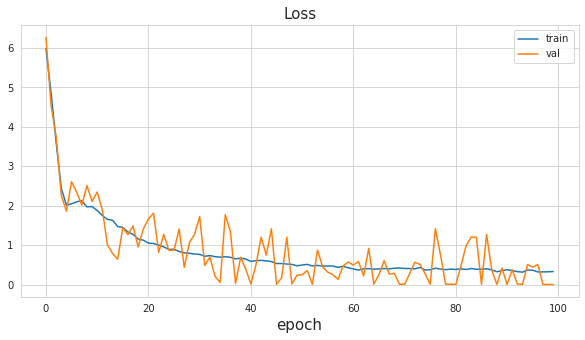

In [56]:
#model with batches old slavinic-rus with hidden size 768

encoder1 = EncoderRNN(train_input_lang.n_words, config['hidden_size'])
attn_decoder1 = AttnDecoderRNN(config['hidden_size'], train_output_lang.n_words, config['MAX_LENGTH'], dropout_p=0.1)
model=TONModel(encoder1, attn_decoder1, config['teacher_forcing_ratio']).to(device)

optimizer = optim.Adam(model.parameters(), lr=config['lr'])
criterion = nn.NLLLoss(ignore_index=0)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',\
#                             factor=0.95, threshold=0.1, min_lr=2e-5, verbose=True)
train_modelIters(model, optimizer, train_loader, test_loader, criterion, config['num_epochs'])

In [57]:
#train old slav - rus hidden size 768
count_bleu(model, train_pairs, train_input_lang, train_output_lang)

0.8646666666666666

In [58]:
#test old slav - rus hidden size 768
count_bleu(model, test_pairs, test_input_lang, test_output_lang)

0.11145833333333333

First clean memory

In [59]:
import gc

gc.collect()

6437

In [60]:
config = {  
    #'path'  :'/content/drive/MyDrive/NLP_translation/old_slav.txt', #old slavenic - rus
    'path':'/content/rus.txt', #rus-eng
    'MAX_LENGTH':20,
    'reverse':True,
    'pad_index':[0,1],
    
    'batch_size':256, # for short datasets use batch_size - 8, for big dataset - 256

    'teacher_forcing_ratio': 0.5,
    'hidden_size':768,
    'num_epochs':25,
    
    'lr': 0.001
}

In [61]:
train_input_lang, train_output_lang, train_pairs, test_input_lang,\
           test_output_lang, test_pairs = prepareData('old_rus', 'new_rus', config['path'], config['MAX_LENGTH'], config['reverse'])
print(random.choice(train_pairs))

Reading lines...


100%|██████████| 440220/440220 [00:00<00:00, 2699838.00it/s]


Read 308153 sentence pairs train
Read 132066 sentence pairs test
Trimmed to 307694 sentence train pairs
Trimmed to 131848 sentence test pairs
Counting words...
Counted words train:
old_rus 16202
new_rus 49403
Counted words test:
old_rus 12234
new_rus 34091
['tom cleared his throat ', 'том откашлялся ', 'cc-by 2 0 (france) attribution: tatoeba org #1095261 (ck) & #2516823 (paul_lingvo)']


In [62]:
training_pairs = [tensorsFromPair(train_pair, train_input_lang, train_output_lang, MAX_LENGTH=config['MAX_LENGTH'])
                      for train_pair in tqdm(train_pairs)]
testing_pairs = [tensorsFromPair(test_pair, test_input_lang, test_output_lang, MAX_LENGTH=config['MAX_LENGTH'])
                      for test_pair in tqdm(test_pairs)]
train_loader = torch.utils.data.DataLoader(training_pairs, batch_size=config['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(testing_pairs, batch_size=config['batch_size'], shuffle=False)   #Test dataloader without shuffling pairs to have comparable results for validation loop                                         

100%|██████████| 131848/131848 [00:09<00:00, 13841.64it/s]


train sample batches: 100%|██████████| 1202/1202 [11:25<00:00,  1.75it/s]

validation sample batches: 100%|██████████| 516/516 [01:10<00:00,  7.37it/s]


Epoch train loss 3.446745224086298
Epoch val_loss 2.800649404525757


train sample batches: 100%|██████████| 1202/1202 [11:25<00:00,  1.75it/s]

validation sample batches: 100%|██████████| 516/516 [01:09<00:00,  7.45it/s]


Epoch train loss 2.209570415305615
Epoch val_loss 2.2433245182037354


train sample batches: 100%|██████████| 1202/1202 [11:25<00:00,  1.75it/s]

validation sample batches: 100%|██████████| 516/516 [01:08<00:00,  7.49it/s]


Epoch train loss 1.8802266407528654
Epoch val_loss 1.9472136497497559


train sample batches: 100%|██████████| 1202/1202 [11:25<00:00,  1.75it/s]

validation sample batches: 100%|██████████| 516/516 [01:09<00:00,  7.45it/s]


Epoch train loss 1.767988371075489
Epoch val_loss 1.7854547500610352


train sample batches: 100%|██████████| 1202/1202 [11:26<00:00,  1.75it/s]

validation sample batches: 100%|██████████| 516/516 [01:09<00:00,  7.39it/s]


Epoch train loss 1.6977923315098995
Epoch val_loss 1.64940345287323


train sample batches: 100%|██████████| 1202/1202 [11:25<00:00,  1.75it/s]

validation sample batches: 100%|██████████| 516/516 [01:08<00:00,  7.49it/s]


Epoch train loss 1.6238504705730572
Epoch val_loss 1.6617116928100586


train sample batches: 100%|██████████| 1202/1202 [11:25<00:00,  1.75it/s]

validation sample batches: 100%|██████████| 516/516 [01:09<00:00,  7.41it/s]


Epoch train loss 1.5733425923671183
Epoch val_loss 1.605912208557129


train sample batches: 100%|██████████| 1202/1202 [11:25<00:00,  1.75it/s]

validation sample batches: 100%|██████████| 516/516 [01:09<00:00,  7.42it/s]


Epoch train loss 1.534240777599633
Epoch val_loss 1.5803353786468506


train sample batches: 100%|██████████| 1202/1202 [11:26<00:00,  1.75it/s]

validation sample batches: 100%|██████████| 516/516 [01:10<00:00,  7.31it/s]


Epoch train loss 1.4994536819751567
Epoch val_loss 1.6190292835235596


train sample batches: 100%|██████████| 1202/1202 [11:26<00:00,  1.75it/s]

validation sample batches: 100%|██████████| 516/516 [01:09<00:00,  7.44it/s]


Epoch train loss 1.4718648751642858
Epoch val_loss 1.5211403369903564


train sample batches: 100%|██████████| 1202/1202 [11:27<00:00,  1.75it/s]

validation sample batches: 100%|██████████| 516/516 [01:10<00:00,  7.33it/s]


Epoch train loss 1.4456695177392436
Epoch val_loss 1.4916443824768066


train sample batches: 100%|██████████| 1202/1202 [11:30<00:00,  1.74it/s]

validation sample batches: 100%|██████████| 516/516 [01:11<00:00,  7.21it/s]


Epoch train loss 1.4261075563716412
Epoch val_loss 1.5146979093551636


train sample batches: 100%|██████████| 1202/1202 [11:30<00:00,  1.74it/s]

validation sample batches: 100%|██████████| 516/516 [01:11<00:00,  7.25it/s]


Epoch train loss 1.4070647965850132
Epoch val_loss 1.4462635517120361


train sample batches: 100%|██████████| 1202/1202 [11:30<00:00,  1.74it/s]

validation sample batches: 100%|██████████| 516/516 [01:10<00:00,  7.36it/s]


Epoch train loss 1.3896158984219176
Epoch val_loss 1.5514605045318604


train sample batches: 100%|██████████| 1202/1202 [11:31<00:00,  1.74it/s]

validation sample batches: 100%|██████████| 516/516 [01:10<00:00,  7.30it/s]


Epoch train loss 1.3738801291897371
Epoch val_loss 1.3616199493408203


train sample batches: 100%|██████████| 1202/1202 [11:32<00:00,  1.74it/s]

validation sample batches: 100%|██████████| 516/516 [01:11<00:00,  7.24it/s]


Epoch train loss 1.36103106883917
Epoch val_loss 1.4424514770507812


train sample batches: 100%|██████████| 1202/1202 [11:33<00:00,  1.73it/s]

validation sample batches: 100%|██████████| 516/516 [01:12<00:00,  7.08it/s]


Epoch train loss 1.3492593624429179
Epoch val_loss 1.3887534141540527


train sample batches: 100%|██████████| 1202/1202 [11:30<00:00,  1.74it/s]

validation sample batches: 100%|██████████| 516/516 [01:10<00:00,  7.35it/s]


Epoch train loss 1.3373340112397358
Epoch val_loss 1.404247522354126


train sample batches: 100%|██████████| 1202/1202 [11:30<00:00,  1.74it/s]

validation sample batches: 100%|██████████| 516/516 [01:10<00:00,  7.33it/s]


Epoch train loss 1.3255232117338704
Epoch val_loss 1.4472852945327759


train sample batches: 100%|██████████| 1202/1202 [11:30<00:00,  1.74it/s]

validation sample batches: 100%|██████████| 516/516 [01:10<00:00,  7.31it/s]


Epoch train loss 1.3137742453525942
Epoch val_loss 1.3763149976730347


train sample batches: 100%|██████████| 1202/1202 [11:28<00:00,  1.75it/s]

validation sample batches: 100%|██████████| 516/516 [01:10<00:00,  7.31it/s]


Epoch train loss 1.3053049564163222
Epoch val_loss 1.4059922695159912


train sample batches: 100%|██████████| 1202/1202 [11:28<00:00,  1.75it/s]

validation sample batches: 100%|██████████| 516/516 [01:10<00:00,  7.31it/s]


Epoch train loss 1.2972138739266927
Epoch val_loss 1.3968243598937988


train sample batches: 100%|██████████| 1202/1202 [11:28<00:00,  1.74it/s]

validation sample batches: 100%|██████████| 516/516 [01:09<00:00,  7.38it/s]


Epoch train loss 1.2867222248813674
Epoch val_loss 1.4510689973831177


train sample batches: 100%|██████████| 1202/1202 [11:28<00:00,  1.75it/s]

validation sample batches: 100%|██████████| 516/516 [01:10<00:00,  7.36it/s]


Epoch train loss 1.2786165506589828
Epoch val_loss 1.3626948595046997


train sample batches: 100%|██████████| 1202/1202 [11:28<00:00,  1.75it/s]

validation sample batches: 100%|██████████| 516/516 [01:10<00:00,  7.31it/s]


Epoch train loss 1.2720365396355233
Epoch val_loss 1.3553520441055298


epochs: 100%|██████████| 25/25 [5:16:43<00:00, 760.15s/it]


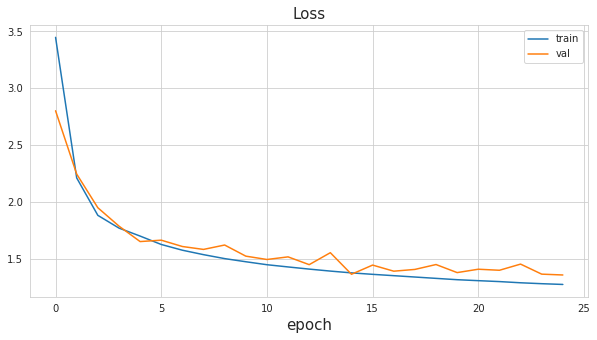

In [63]:
#model with batches rus-eng

encoder1 = EncoderRNN(train_input_lang.n_words, config['hidden_size'])
attn_decoder1 = AttnDecoderRNN(config['hidden_size'], train_output_lang.n_words, config['MAX_LENGTH'], dropout_p=0.1)
model=TONModel(encoder1, attn_decoder1, config['teacher_forcing_ratio']).to(device)

optimizer = optim.Adam(model.parameters(), lr=config['lr'])
criterion = nn.NLLLoss(ignore_index=0)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',\
#                             factor=0.95, threshold=0.1, min_lr=2e-5, verbose=True)
train_modelIters(model, optimizer, train_loader, test_loader, criterion, config['num_epochs'])

Look at translation results

In [64]:
evaluateRandomly(model, train_pairs, train_input_lang, train_output_lang)

> they must be punished 
= они должны быть наказаны 
< они должны быть наказаны  наказаны

Blue score of this sentence  -  0

Blue score of this sentence my function -  0.9875
> do you think i'm a thief 
= вы думаете  я вор 
< думаешь   я   я

Blue score of this sentence  -  0.03455747170954952

Blue score of this sentence my function -  0.575
> i'm totally confused 
= я в полном замешательстве 
< я в замешательстве  замешательстве  замешательстве  замешательстве  замешательстве  замешательстве  замешательстве  замешательстве  замешательстве 

Blue score of this sentence  -  0.06389431042462725

Blue score of this sentence my function -  0.4
> it's in my backpack 
= он у меня в рюкзаке 
< он у меня в рюкзаке               

Blue score of this sentence  -  0.041095991233501536

Blue score of this sentence my function -  0.825
> no one wants to talk about what happened 
= никто не хочет говорить о том  что произошло 
< никто не хочет говорить о произошедшем  что произошло  что произошло 

In [65]:
evaluateRandomly(model, test_pairs, test_input_lang, test_output_lang)

> tom and mary live near each other 
= том и мэри живут рядом друг с другом 
< так они они они они они они они они этом

Blue score of this sentence  -  0.023980296761827107

Blue score of this sentence my function -  0.125
> i hope that no one saw me 
= надеюсь  меня никто не видел 
< не получили у этих тем этих тем этих тем этих тем этих тем этих тем этих тем этих тем этих

Blue score of this sentence  -  0

Blue score of this sentence my function -  0.0
> tom is very pious 
= том очень набожен 
< из-за никогда этои никогда этом

Blue score of this sentence  -  0

Blue score of this sentence my function -  0.1875
> how do you feel today 
= как вы себя сегодня чувствуете 
< в  фотографии фотографии фотографии фотографии фотографии

Blue score of this sentence  -  0

Blue score of this sentence my function -  0.1625
> there's been a burglary 
= произошла кража со взломом 
< сын посмотрел на "это за этим              

Blue score of this sentence  -  0

Blue score of this sentence my fu

In [73]:
#train eng - rus hidden size 768
count_bleu(model, train_pairs, train_input_lang, train_output_lang)

0.7190209943428645

In [74]:
#test eng - rus hidden size 768
count_bleu(model, test_pairs, test_input_lang, test_output_lang)

0.0811086440446575